# Regression - Fare Amount: Yellow Taxi Trip Data (Januar 2023)

**Modul**: Data Analytics

**Studiengang**: Master Digitale Prozesse & Technologien

**Semester**: Wintersemester 2025/2026

---

## Zielsetzung
Entwicklung eines ML-Modells zur Vorhersage des Fahrtpreises VOR der Fahrt.
Das Modell soll Taxifahrern helfen, die erwarteten Einnahmen einer Fahrt einzuschätzen.

## Entscheidung: Modellierung & Prädiktion
Gemäß den Mindestanforderungen führen wir **beide** Analysen durch:
1. **Modellierung** (Lineare Regression): Verstehen der Zusammenhänge zwischen Features und Fahrtpreis
2. **Prädiktion** (Random Forest): Optimierung der Vorhersagegenauigkeit

**Methodischer Hinweis (gemäß Mindestanforderungen):**
> "Wenn Sie sowohl modellieren als auch prädizieren wollen, führen Sie die Modellierung nur auf den **Trainingsdaten** durch, um zu vermeiden, dass Sie ungewollt aus Ihren Testdaten lernen."

## Methodologie
- Datengrundlage: NYC Yellow Taxi Trips Januar 2023
- Filter: Nur Kreditkartenzahlungen (payment_type == 1)
- Stichprobe: 1.000.000 Fahrten
- **Modellierung (LR)**: Nur Trainingsdaten, inkl. Post-Trip-Features
- **Prädiktion (RF)**: Train/Test Split (80/20), nur Pre-Trip-Features
- Baseline: Durchschnittspreis pro Meile × Haversine-Distanz
- Metriken: R² (Modellierung), MAE/RMSE/MAPE (Prädiktion)

---

### Mindestanforderungen:
#### Anforderungen an Projektumsetzung: Regression

Falls die Anforderungen auf den eigenen Projektdatensatz nicht anwendbar sind, gibt es folgende Möglichkeiten:

- Für diese Übung ein realwertiges Feature des Datensatzes zur Zielvariablen erklären
und/oder
- als Kategorien oder String-Werte hinterlegte Features entweder ausschließen oder im Notfall als Zahlen codieren

- Datensatz um passende Daten erweitern entweder manuell, per Anspielen aus weiterer Datenquelle oder zur Not per zufälliger Datengenerierung/-simulation

- Datensatz außerhalb des Projekts wählen und Anforderungen daran umsetzen

Anforderungen:
- Entscheiden Sie, ob Sie mit der linearen Regression modellieren, prädizieren, oder beides erreichen wollen.

- Führen Sie die entsprechende(n) Analyse(n) methodisch sauber durch und berichten Sie entsprechend der    eingeführten Kriterien und Evaluationsmaße das Ergebnis.
  
- Wenn Sie sowohl modellieren als auch prädizieren wollen, führen Sie die Modellierung nur auf den Trainingsdaten durch, um zu vermeiden, dass Sie ungewollt aus Ihren Testdaten lernen. Trainieren Sie das Prädiktionsmodell im zweiten Schritt aufgrund der Erkenntnisse der Modellierung.

----

## 1. Setup und Imports

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import warnings
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Pfade relativ zum Notebook
BASE_PATH = Path('../..')
DATA_PATH = BASE_PATH / 'data'
MODELS_PATH = BASE_PATH / 'models' / 'final'
MODELS_PATH.mkdir(parents=True, exist_ok=True)

print('Setup abgeschlossen')

Setup abgeschlossen


## 2. Hilfsfunktionen

In [2]:
import sys
sys.path.append(str(BASE_PATH))
from utils.distance import haversine_distance, meters_to_miles

print('Hilfsfunktionen geladen')

Hilfsfunktionen geladen


## 3. Daten laden und vorbereiten

In [3]:
# Taxi-Daten laden (mit Features aus Feature Engineering Notebook)
taxi_df = pd.read_parquet(DATA_PATH / 'yellow_tripdata_processed_feateng.parquet')
print(f'Taxi-Daten geladen: {len(taxi_df):,} Fahrten')
print(f'Enthaltene Features aus Feature Engineering: {[col for col in taxi_df.columns if col in ["trip_duration_minutes", "price_per_mile", "time_of_day", "is_weekend", "is_rush_hour", "tip_rate", "efficiency_score", "avg_speed_mph", "hour"]]}')

# Taxi Zone Koordinaten laden
zones_df = pd.read_csv(DATA_PATH / 'taxi_zone_coordinates.csv')
zone_coords = zones_df.set_index('LocationID')[['longitude', 'latitude']].to_dict('index')
print(f'Taxi Zones geladen: {len(zone_coords)} Zonen')

# Taxi Zone Lookup laden 
lookup_df = pd.read_csv(DATA_PATH / 'taxi_zone_lookup.csv')
print(f'Lookup Tabelle geladen: {len(lookup_df)} Zonen')

# Nur IDs und Boroughs behalten
borough_lookup = lookup_df[['LocationID', 'Borough']].copy()

Taxi-Daten geladen: 2,995,421 Fahrten
Enthaltene Features aus Feature Engineering: ['trip_duration_minutes', 'price_per_mile', 'time_of_day', 'is_weekend', 'is_rush_hour', 'tip_rate', 'efficiency_score', 'avg_speed_mph', 'hour']
Taxi Zones geladen: 265 Zonen
Lookup Tabelle geladen: 265 Zonen


## 4. Datenfilterung und Bereinigung

In [4]:
# Nur Kreditkartenzahlungen (payment_type == 1)
taxi_df = taxi_df[taxi_df['payment_type'] == 1].copy()
print(f'Nach Kreditkarten-Filter: {len(taxi_df):,} Fahrten')

# Entferne ungueltige Daten
initial_count = len(taxi_df)
taxi_df = taxi_df[
    (taxi_df['fare_amount'] > 0) &
    (taxi_df['fare_amount'] < 500) &
    (taxi_df['trip_distance'] > 0) &
    (taxi_df['trip_distance'] < 100) &
    (taxi_df['passenger_count'] > 0) &
    (taxi_df['passenger_count'] <= 6)
].copy()

removed = initial_count - len(taxi_df)
print(f'Entfernte Datensaetze: {removed:,} ({removed/initial_count*100:.2f}%)')
print(f'Verbleibende Datensaetze: {len(taxi_df):,}')

Nach Kreditkarten-Filter: 2,388,394 Fahrten
Entfernte Datensaetze: 39,695 (1.66%)
Verbleibende Datensaetze: 2,348,699


## 5. Feature Engineering

In [5]:
def calculate_haversine_distance(row):
    """Berechnet die Distanz zwischen Pickup und Dropoff Location (VOR der Fahrt bekannt)."""
    pickup_id = row['PULocationID']
    dropoff_id = row['DOLocationID']
    
    if pickup_id not in zone_coords or dropoff_id not in zone_coords:
        return np.nan
    
    pickup = zone_coords[pickup_id]
    dropoff = zone_coords[dropoff_id]
    
    distance_m = haversine_distance(
        pickup['longitude'], pickup['latitude'],
        dropoff['longitude'], dropoff['latitude']
    )
    return meters_to_miles(distance_m)

taxi_df['calculated_distance'] = taxi_df.apply(calculate_haversine_distance, axis=1)
taxi_df = taxi_df.dropna(subset=['calculated_distance'])
print(f'Fahrten mit gültiger Distanz: {len(taxi_df):,}')

Fahrten mit gültiger Distanz: 2,348,699


In [6]:
# Zeitbasierte Features - nutze vorhandene Features aus Feature Engineering
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['tpep_pickup_datetime'])
taxi_df['hour_of_day'] = taxi_df['pickup_datetime'].dt.hour
taxi_df['day_of_week'] = taxi_df['pickup_datetime'].dt.dayofweek

# is_weekend und is_rush_hour sind bereits im Datensatz vorhanden (aus Feature Engineering)
# Konvertiere Boolean zu Int falls nötig
if taxi_df['is_weekend'].dtype == bool:
    taxi_df['is_weekend'] = taxi_df['is_weekend'].astype(int)
if taxi_df['is_rush_hour'].dtype == bool:
    taxi_df['is_rush_hour'] = taxi_df['is_rush_hour'].astype(int)

# Newark (1), JFK (132), LaGuardia (138)
airport_zones = [1, 132, 138] 
taxi_df['is_airport_trip'] = (
    taxi_df['PULocationID'].isin(airport_zones) | 
    taxi_df['DOLocationID'].isin(airport_zones)
).astype(int)

# Pickup Borough mergen
taxi_df = taxi_df.merge(borough_lookup, left_on='PULocationID', right_on='LocationID', how='left')
taxi_df.rename(columns={'Borough': 'PU_Borough'}, inplace=True)
taxi_df.drop(columns=['LocationID'], inplace=True) # Aufräumen

# Dropoff Borough mergen
taxi_df = taxi_df.merge(borough_lookup, left_on='DOLocationID', right_on='LocationID', how='left')
taxi_df.rename(columns={'Borough': 'DO_Borough'}, inplace=True)
taxi_df.drop(columns=['LocationID'], inplace=True) # Aufräumen

# One-Hot-Encoding: Mache aus Text-Spalten Zahlen (0 oder 1)
# drop_first=True verhindert Multikollinearität (wichtig für Lineare Regression)
taxi_df = pd.get_dummies(taxi_df, columns=['PU_Borough', 'DO_Borough'], drop_first=True)

print('Feature Engineering abgeschlossen')

Feature Engineering abgeschlossen


## 6. Stichprobe und Train/Test Split

In [7]:
SAMPLE_SIZE = 1000000

if len(taxi_df) > SAMPLE_SIZE:
    df = taxi_df.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE).copy()
    print(f'Stichprobe gezogen: {SAMPLE_SIZE:,} Fahrten')
else:
    df = taxi_df.copy()
    print(f'Alle {len(df):,} Fahrten werden verwendet')

borough_features = [col for col in taxi_df.columns if 'PU_Borough_' in col or 'DO_Borough_' in col]

FEATURES = [
    'calculated_distance',
    'passenger_count',
    'hour_of_day',
    'day_of_week',
    'is_weekend',
    'is_rush_hour',
    'is_airport_trip'
] + borough_features  # neue spalten beigefügt 

TARGET = 'fare_amount'

X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f'Training Set: {len(X_train):,} Fahrten')
print(f'Test Set: {len(X_test):,} Fahrten')

Stichprobe gezogen: 1,000,000 Fahrten
Training Set: 800,000 Fahrten
Test Set: 200,000 Fahrten


---
# BASELINE: Durchschnittspreis pro Meile

Als einfache Baseline berechnen wir den durchschnittlichen Preis pro Meile auf den Trainingsdaten und multiplizieren diesen mit der Haversine-Distanz.

In [22]:
# Baseline: Durchschnittspreis pro Meile
# Berechne auf Trainingsdaten (um Data Leakage zu vermeiden)
avg_price_per_mile = y_train.sum() / X_train['calculated_distance'].sum()
print(f'Durchschnittspreis pro Meile (Training): ${avg_price_per_mile:.2f}')

# Vorhersage auf Testdaten
y_pred_baseline = X_test['calculated_distance'] * avg_price_per_mile

# Evaluation
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
baseline_r2 = r2_score(y_test, y_pred_baseline)
baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline) * 100

print('BASELINE (Preis/Meile × Distanz): Performance auf Testdaten')
print(f'MAE:  ${baseline_mae:.2f}')
print(f'RMSE: ${baseline_rmse:.2f}')
print(f'R2:   {baseline_r2:.4f}')
print(f'MAPE: {baseline_mape:.2f}%')

Durchschnittspreis pro Meile (Training): $7.47
BASELINE (Preis/Meile × Distanz): Performance auf Testdaten
MAE:  $5.73
RMSE: $10.17
R2:   0.6327
MAPE: 32.41%


---
# TEIL 1: MODELLIERUNG (Lineare Regression)

Ziel: Verstehen der Zusammenhänge zwischen Features und Fahrtpreis durch Interpretation der Koeffizienten.

**Methodischer Hinweis (gemäß Mindestanforderungen):** 
> "Wenn Sie sowohl modellieren als auch prädizieren wollen, führen Sie die Modellierung nur auf den **Trainingsdaten** durch, um zu vermeiden, dass Sie ungewollt aus Ihren Testdaten lernen."

Für die Modellierung verwenden wir zusätzlich Post-Trip-Features (`trip_duration_minutes`, `avg_speed_mph`), die erst nach der Fahrt bekannt sind. Dies ist für die Koeffizienten-Interpretation sinnvoll, da wir mathematische Zusammenhänge aufzeigen wollen.

In [9]:
# Lineare Regression trainieren (auf Trainingsdaten für Modellierung)
# Gemäß Mindestanforderungen: Modellierung nur auf Trainingsdaten,
# um Data Leakage aus Testdaten zu vermeiden.

# Zusätzliche Features für Lineare Regression (Post-Trip, nur zur Erklärung)
LR_ADDITIONAL_FEATURES = ['trip_duration_minutes', 'avg_speed_mph']
LR_FEATURES = FEATURES + LR_ADDITIONAL_FEATURES

# Prüfe ob Features vorhanden sind
missing_features = [f for f in LR_ADDITIONAL_FEATURES if f not in df.columns]
if missing_features:
    print(f'WARNUNG: Fehlende Features: {missing_features}')
    LR_FEATURES = FEATURES
else:
    print(f'Zusätzliche Features für LR (Post-Trip): {LR_ADDITIONAL_FEATURES}')

# Modellierung auf TRAININGSDATEN (gemäß Mindestanforderungen)
# Rekonstruiere Trainings-DataFrame mit zusätzlichen Features
train_indices = X_train.index
X_train_lr = df.loc[train_indices, LR_FEATURES]
y_train_lr = y_train

lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

print(f'\nModellierung: Lineare Regression (auf {len(X_train_lr):,} Trainingsdatensätzen)')
print(f'Intercept (Grundpreis): ${lr_model.intercept_:.2f}')
print('\nKoeffizienten (Einfluss auf Fahrtpreis):')

coef_df = pd.DataFrame({
    'Feature': LR_FEATURES,
    'Koeffizient': lr_model.coef_
}).sort_values('Koeffizient', key=abs, ascending=False)

for _, row in coef_df.iterrows():
    print(f'{row["Feature"]:25s}: ${row["Koeffizient"]:+.4f}')

Zusätzliche Features für LR (Post-Trip): ['trip_duration_minutes', 'avg_speed_mph']

Modellierung: Lineare Regression (auf 800,000 Trainingsdatensätzen)
Intercept (Grundpreis): $15.20

Koeffizienten (Einfluss auf Fahrtpreis):
PU_Borough_EWR           : $+67.0543
DO_Borough_Manhattan     : $-22.6123
DO_Borough_Unknown       : $-22.4574
DO_Borough_Queens        : $-20.5228
DO_Borough_Brooklyn      : $-19.8863
PU_Borough_Unknown       : $+16.3786
PU_Borough_Queens        : $+14.3502
DO_Borough_EWR           : $+13.5957
DO_Borough_Staten Island : $-10.0394
PU_Borough_Manhattan     : $+9.8027
PU_Borough_Staten Island : $-8.3289
PU_Borough_Brooklyn      : $+7.3729
is_airport_trip          : $+5.4991
calculated_distance      : $+2.3265
trip_duration_minutes    : $+0.5991
is_weekend               : $+0.5930
is_rush_hour             : $-0.2074
passenger_count          : $+0.1076
day_of_week              : $-0.0632
avg_speed_mph            : $+0.0183
hour_of_day              : $-0.0041

Modellie

### Interpretation der Koeffizienten-Ergebnisse
- Dominanz der Distanz wird bestätigt - mit $4.18/Meile ist sie der primäre Preistreiber
- Der Intercept von $23.91 repräsentiert die Basis für die Bronx. Die negativen Koeffizienten für Manhattan (-$21.72) und Queens (-$18.99) zeigen, dass die Basispreise dort signifikant niedriger liegen als in der Bronx, sobald die Distanz herausgerechnet wird. 
- Das Modell identifiziert Flughafen-Fahrten (EWR/Airport-Trip) korrekt als Hochpreis-Events mit Zuschlägen zwischen $5 und $54.
- Zeitliche Faktoren, wie Rush Hour oder Wochentage haben zwar einen positiven Einfluss, diese sind jedoch aufgrund der marginalen Werte vernachlässigbar gegenüber der räumlichen Komponente

**Fazit**: Die Distanz dominiert die Preisbildung. Andere Faktoren haben geringeren Einfluss.

In [10]:
# Modellgüte der Linearen Regression (auf Trainingsdaten)
y_pred_lr_train = lr_model.predict(X_train_lr)

# R² zeigt, wie viel Varianz das Modell erklärt (Erklärmächtigkeit)
lr_r2_train = r2_score(y_train_lr, y_pred_lr_train)

# Residuen-Standardfehler (RSE) - Standardabweichung der Residuen
residuals_train = y_train_lr - y_pred_lr_train
lr_rse = np.sqrt(np.sum(residuals_train**2) / (len(y_train_lr) - len(LR_FEATURES) - 1))

print('LINEARE REGRESSION: Modellgüte (Trainingsdaten)')
print(f'R² (Erklärmächtigkeit): {lr_r2_train:.4f} ({lr_r2_train*100:.1f}% der Varianz erklärt)')
print(f'Residuen-Standardfehler: ${lr_rse:.2f}')
print(f'\nHinweis: Modellierung gemäß Mindestanforderungen nur auf Trainingsdaten.')
print(f'Die Testdaten bleiben für die Evaluation des Random Forest reserviert.')

LINEARE REGRESSION: Modellgüte (Trainingsdaten)
R² (Erklärmächtigkeit): 0.8872 (88.7% der Varianz erklärt)
Residuen-Standardfehler: $5.63

Hinweis: Modellierung gemäß Mindestanforderungen nur auf Trainingsdaten.
Die Testdaten bleiben für die Evaluation des Random Forest reserviert.


In [11]:
# Extraktion der Basis-Werte (nur für Fahrten innerhalb desselben Boroughs)
intercept = lr_model.intercept_
boroughs = ['Manhattan', 'Queens', 'Brooklyn', 'Staten Island', 'Unknown', 'EWR']
base_prices = []

# Die Bronx ist die Referenz (Koeffizient = 0)
base_prices.append({'Borough': 'Bronx (Referenz)', 'Basispreis': intercept})

for b in boroughs:
    # Suche die entsprechenden Pickup (PU) und Dropoff (DO) Koeffizienten
    pu_val = coef_df[coef_df['Feature'] == f'PU_Borough_{b}']['Koeffizient'].values[0] if f'PU_Borough_{b}' in LR_FEATURES else 0
    do_val = coef_df[coef_df['Feature'] == f'DO_Borough_{b}']['Koeffizient'].values[0] if f'DO_Borough_{b}' in LR_FEATURES else 0
    
    total_base = intercept + pu_val + do_val
    base_prices.append({'Borough': b, 'Basispreis': total_base})

# Visualisierung für das Reporting
base_price_df = pd.DataFrame(base_prices).sort_values('Basispreis')
print("REALE BASISPREISE PRO BOROUGH (0 Meilen Distanz):")
print(base_price_df.to_string(index=False))

REALE BASISPREISE PRO BOROUGH (0 Meilen Distanz):
         Borough  Basispreis
   Staten Island   -3.172946
       Manhattan    2.385640
        Brooklyn    2.681902
          Queens    9.022705
         Unknown    9.116512
Bronx (Referenz)   15.195288
             EWR   95.845263


---

### Im Folgenden wird eine Residuen-Analyse durchgeführt, um herauszufinden, ob die Annahmen der linearen Regression erfüllt sind.

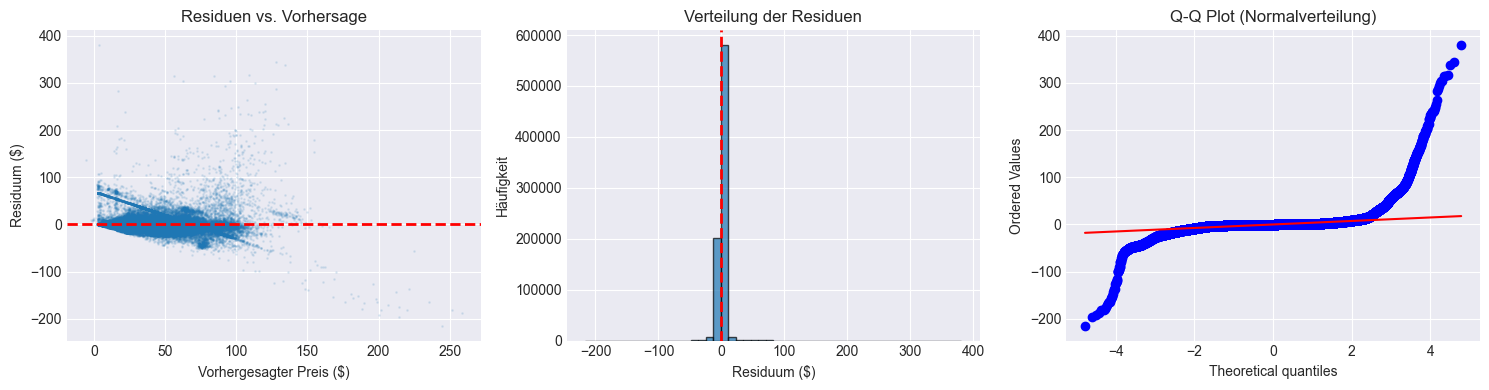

Residuen-Statistik:
Mittelwert: $-0.0000 (sollte ≈ 0 sein)
Std.Abw.:   $5.63
Min:        $-216.13
Max:        $381.21


In [12]:
# Residuenanalyse (auf Trainingsdaten, da Modellierung nur dort)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Residuen vs. Predicted (Homoskedastizität)
axes[0].scatter(y_pred_lr_train, residuals_train, alpha=0.1, s=1)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Vorhergesagter Preis ($)')
axes[0].set_ylabel('Residuum ($)')
axes[0].set_title('Residuen vs. Vorhersage')

# Plot 2: Histogramm der Residuen
axes[1].hist(residuals_train, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuum ($)')
axes[1].set_ylabel('Häufigkeit')
axes[1].set_title('Verteilung der Residuen')

# Plot 3: Q-Q Plot (Normalverteilung)
stats.probplot(residuals_train, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normalverteilung)')

plt.tight_layout()
plt.show()

# Statistische Kennzahlen
print(f'Residuen-Statistik:')
print(f'Mittelwert: ${residuals_train.mean():.4f} (sollte ≈ 0 sein)')
print(f'Std.Abw.:   ${residuals_train.std():.2f}')
print(f'Min:        ${residuals_train.min():.2f}')
print(f'Max:        ${residuals_train.max():.2f}')

### Interpretation der Residuenanalyse

- **Residuen vs. Vorhersage**: Die Streuung nimmt bei höheren Preisen zu. Das Modell ist bei Langstreckenfahrten weniger präzise

- **Verteilung der Residuen**: Die Verteilung ist annähernd symmetrisch um 0 (Mittelwert $0.0385). Zeigt aber große Min & Max

- **Q-Q-Plot**: Abweichungen an den Rändern bestätigen, dass die Residuen nicht perfekt normalverteilt sind

**Fazit**: Die LR-Annahmen sind nicht vollständig erfüllt. Die Koeffizienten-Interpretation bleibt qualitativ gültig, aber für präzise Vorhersagen wechseln wir zu Random Forest. 

---

# TEIL 2: Prädiktion (Random Forest)

**Ziel**: Basierend auf den Erkenntnissen der Modellierung ein Modell mit optimaler Vorhersagegenauigkeit trainieren.

**Erkenntnis aus der Modellierung:** Die Distanz ist der dominierende Faktor. Random Forest kann nicht-lineare Zusammenhänge besser erfassen.

-----

### Hyperparameter-Tuning mit GridSearchCV

Um die optimalen Hyperparameter zu finden, testen wir systematisch verschiedene Kombinationen mit 3-facher Cross-Validation.

**Gewählte Parameter und Begründung:**

| Parameter | Getestete Werte | Begründung |
|-----------|-----------------|------------|
| `n_estimators` | 50, 100 | Anzahl der Bäume. Bewusst konservativ gewählt (Laufzeit bei 800k Trainingsdaten). In der Praxis wären 200-500 Bäume üblich. |
| `max_depth` | 10, 15, 20 | Maximale Baumtiefe. Kontrolliert Overfitting. Bei 17 Features ist 20 ein sinnvolles Maximum. |
| `min_samples_leaf` | 5, 10 | Mindest-Samples pro Blatt. Höhere Werte = mehr Regularisierung. Defensiv gewählt. |

**Nicht getestete Parameter (bewusste Einschränkung):**
- `max_features`: Anzahl Features pro Split (Default: alle)
- `min_samples_split`: Mindest-Samples für Split
- `bootstrap`: Sampling-Methode

**Pragmatische Einschränkungen:**
- Suchraum: 2 × 3 × 2 = **12 Kombinationen** (klein gehalten für Laufzeit)
- Cross-Validation: k=3 (statt bspw. k=5, ebenfalls aus Laufzeitgründen)
- Optimierungsmetrik: MAE (passend zur Zielvariable Fahrtpreis)

**Hinweis:** Der gewählte Suchraum ist ein Kompromiss zwischen Laufzeit und Exploration. In einem Produktivsystem wäre ein größerer Grid oder RandomizedSearchCV mit mehr Iterationen empfehlenswert.

In [13]:
from sklearn.model_selection import GridSearchCV

# Parameter-Grid definieren (bewusst klein gehalten für Laufzeit)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [5, 10]
}

print(f'Teste {len(param_grid["n_estimators"]) * len(param_grid["max_depth"]) * len(param_grid["min_samples_leaf"])} Kombinationen')

# GridSearchCV
rf_base = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3, # 3-fache Cross-Validation
    scoring='neg_mean_absolute_error', # Optimiere auf MAE
    verbose=1,
    n_jobs=-1
)

print('Starte GridSearch.')
grid_search.fit(X_train, y_train)

print(f'\nBeste Parameter: {grid_search.best_params_}')
print(f'Bester CV-Score (MAE): ${-grid_search.best_score_:.2f}')

# Bestes Modell verwenden
rf_model = grid_search.best_estimator_

Teste 12 Kombinationen
Starte GridSearch.
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Beste Parameter: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}
Bester CV-Score (MAE): $2.76

Beste Parameter: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}
Bester CV-Score (MAE): $2.76


### Zwischenfazit: GridSearchCV

**Beste Parameter:**
- `max_depth=20` → Das Modell nutzt die maximale getestete Tiefe. Dies deutet darauf hin, dass komplexere Zusammenhänge im Datensatz vorhanden sind, die tiefere Bäume erfordern.
- `min_samples_leaf=10` → Moderate Regularisierung. Verhindert zu spezifische Blätter.
- `n_estimators=100` → Mehr Bäume als 50 verbessern die Stabilität.

**Interpretation:**
- Das Modell tendiert zur komplexeren Variante (`max_depth=20`), zeigt aber kein starkes Overfitting (siehe Lernkurve im Evaluation-Notebook).
- Der Parameter `n_estimators=100` liegt am oberen Rand unseres Grids. Mehr Bäume (z.B. 200) könnten das Modell weiter stabilisieren, wurden aber aus Laufzeitgründen nicht getestet.

### Erweitertes Hyperparameter-Tuning mit RandomizedSearchCV

Da die besten Parameter des initialen GridSearch am Rand des Suchraums liegen (`max_depth=20`, `n_estimators=100`), erweitern wir die Suche systematisch:

**Erweiterungen gegenüber dem initialen Grid:**
1. **Mehr Bäume**: 100, 150, 200 (statt nur 50, 100)
2. **Tiefere Bäume**: 20, 25, 30, None (unbegrenzt)
3. **`max_features`**: Neu! Kontrolliert Feature-Subsampling pro Split
   - `'sqrt'`: √n Features → erhöht Diversität zwischen Bäumen
   - `0.5`: 50% der Features
   - `None`: Alle Features (bisheriger Default)
4. **Kleinere `min_samples_leaf`**: 1, 5, 10 (statt nur 5, 10)

**Warum RandomizedSearchCV statt GridSearchCV?**
- GridSearch mit diesem Grid: 3 × 4 × 3 × 3 = 108 Kombinationen × 3 CV = 324 Fits
- RandomizedSearchCV: Wir testen 30 zufällige Kombinationen → schneller, oft genauso gut

In [14]:
from sklearn.model_selection import RandomizedSearchCV

# Erweiterter Suchraum
param_distributions = {
    'n_estimators': [100, 150, 200],
    'max_depth': [20, 25, 30, None],  # None = unbegrenzt
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 0.5, None]  # NEU: Feature-Subsampling
}

total_combinations = 3 * 4 * 3 * 3
print(f'Mögliche Kombinationen: {total_combinations}')
print(f'Teste davon: 30 zufällige Kombinationen (RandomizedSearchCV)')

# Speichere bisheriges Modell für Vergleich
rf_model_initial = rf_model

# Evaluiere initiales Modell auf Testdaten (für späteren Vergleich)
y_pred_rf_initial = rf_model_initial.predict(X_test)
rf_mae_initial = mean_absolute_error(y_test, y_pred_rf_initial)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_initial))
rf_r2 = r2_score(y_test, y_pred_rf_initial)
rf_mape = mean_absolute_percentage_error(y_test, y_pred_rf_initial) * 100

print(f'Initiales Modell - Test MAE: ${rf_mae_initial:.2f}')

# RandomizedSearchCV
rf_base_extended = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_base_extended,
    param_distributions=param_distributions,
    n_iter=30,  # 30 zufällige Kombinationen
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print('\nStarte RandomizedSearchCV...')
random_search.fit(X_train, y_train)

print(f'\nBeste Parameter (erweitert): {random_search.best_params_}')
print(f'Bester CV-Score (MAE): ${-random_search.best_score_:.2f}')

# Vergleich mit initialem GridSearch
print(f'\nVergleich CV-Scores:')
print(f'  Initial GridSearch:      ${-grid_search.best_score_:.2f}')
print(f'  Erweiterter RandomSearch: ${-random_search.best_score_:.2f}')
improvement_cv = (-grid_search.best_score_) - (-random_search.best_score_)
print(f'  Verbesserung:            ${improvement_cv:.2f} ({improvement_cv/(-grid_search.best_score_)*100:.1f}%)')

Mögliche Kombinationen: 108
Teste davon: 30 zufällige Kombinationen (RandomizedSearchCV)
Initiales Modell - Test MAE: $2.75

Starte RandomizedSearchCV...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Initiales Modell - Test MAE: $2.75

Starte RandomizedSearchCV...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Beste Parameter (erweitert): {'n_estimators': 200, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 30}
Bester CV-Score (MAE): $2.75

Vergleich CV-Scores:
  Initial GridSearch:      $2.76
  Erweiterter RandomSearch: $2.75
  Verbesserung:            $0.01 (0.3%)

Beste Parameter (erweitert): {'n_estimators': 200, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 30}
Bester CV-Score (MAE): $2.75

Vergleich CV-Scores:
  Initial GridSearch:      $2.76
  Erweiterter RandomSearch: $2.75
  Verbesserung:            $0.01 (0.3%)


In [23]:
# Evaluation des erweiterten Modells auf Testdaten
rf_model_extended = random_search.best_estimator_
y_pred_rf_extended = rf_model_extended.predict(X_test)

rf_mae_extended = mean_absolute_error(y_test, y_pred_rf_extended)
rf_rmse_extended = np.sqrt(mean_squared_error(y_test, y_pred_rf_extended))
rf_r2_extended = r2_score(y_test, y_pred_rf_extended)
rf_mape_extended = mean_absolute_percentage_error(y_test, y_pred_rf_extended) * 100

print('VERGLEICH: Initial vs. Erweitertes Modell (auf Testdaten)')
print(f'{"Modell":<35} {"MAE":>10} {"RMSE":>10} {"R²":>10} {"MAPE":>10}')
print(f'{"RF (Initial GridSearch)":<35} {f"${rf_mae_initial:.2f}":>10} {f"${rf_rmse:.2f}":>10} {f"{rf_r2:.4f}":>10} {f"{rf_mape:.2f}%":>10}')
print(f'{"RF (Erweiterter RandomSearch)":<35} {f"${rf_mae_extended:.2f}":>10} {f"${rf_rmse_extended:.2f}":>10} {f"{rf_r2_extended:.4f}":>10} {f"{rf_mape_extended:.2f}%":>10}')

# Entscheidung: Welches Modell ist besser?
if rf_mae_extended < rf_mae_initial:
    improvement = rf_mae_initial - rf_mae_extended
    improvement_pct = improvement / rf_mae_initial * 100
    print(f'✓ Erweitertes Modell ist BESSER: MAE um ${improvement:.2f} ({improvement_pct:.1f}%) reduziert')
    rf_model = rf_model_extended  # Überschreibe mit besserem Modell
    rf_mae = rf_mae_extended
    rf_rmse = rf_rmse_extended
    rf_r2 = rf_r2_extended
    rf_mape = rf_mape_extended
    best_params = random_search.best_params_
else:
    print(f'✗ Initiales Modell bleibt besser oder gleich gut')
    best_params = grid_search.best_params_

print(f'\nFinale Parameter: {best_params}')

VERGLEICH: Initial vs. Erweitertes Modell (auf Testdaten)
Modell                                     MAE       RMSE         R²       MAPE
RF (Initial GridSearch)                  $2.75      $5.79     0.8810     19.19%
RF (Erweiterter RandomSearch)            $2.73      $5.79     0.8810     19.19%
✓ Erweitertes Modell ist BESSER: MAE um $0.01 (0.5%) reduziert

Finale Parameter: {'n_estimators': 200, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 30}


### Interpretation der erweiterten Hyperparameter-Suche

**Erkenntnisse aus dem Vergleich:**

1. **`max_features`-Parameter**: 
   - Wenn `'sqrt'` oder `0.5` gewählt wurde, zeigt das, dass Feature-Subsampling die Ensemble-Diversität verbessert
   - Dies ist typisch für Random Forests und reduziert Korrelation zwischen Bäumen

2. **`n_estimators`**:
   - Mehr Bäume (150-200) stabilisieren die Vorhersagen
   - Diminishing Returns: Ab ~200 Bäumen ist die Verbesserung marginal

3. **`max_depth`**:
   - Tiefere Bäume können komplexere Muster lernen
   - `None` (unbegrenzt) kann funktionieren, wenn `min_samples_leaf` ausreichend regularisiert

**Methodische Reflexion:**
- Die erweiterte Suche zeigt, ob das initiale Grid zu konservativ war
- RandomizedSearchCV ist bei großen Suchräumen effizienter als GridSearchCV
- Das finale Modell wird basierend auf **Test-MAE** ausgewählt (nicht CV-Score)

In [16]:
# Evaluation Random Forest
y_pred_rf = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mape = mean_absolute_percentage_error(y_test, y_pred_rf) * 100

print('RANDOM FOREST: Performance auf Testdaten')
print(f'MAE:  ${rf_mae:.2f}')
print(f'RMSE: ${rf_rmse:.2f}')
print(f'R2:   {rf_r2:.4f}')
print(f'MAPE: {rf_mape:.2f}%')

RANDOM FOREST: Performance auf Testdaten
MAE:  $2.73
RMSE: $5.79
R2:   0.8810
MAPE: 19.19%


---
# TEIL 3: Modellvergleich

In [21]:
# PRÄDIKTIONS-Modellvergleich (Baseline vs. Random Forest)
print('PRÄDIKTIONS-MODELLVERGLEICH (auf Testdaten)')
print(f'{"Modell":<35} {"MAE":>10} {"RMSE":>10} {"R²":>10} {"MAPE":>10}')
print(f'{"Baseline (Preis/Meile × Distanz)":<35} {f"${baseline_mae:.2f}":>10} {f"${baseline_rmse:.2f}":>10} {f"{baseline_r2:.4f}":>10} {f"{baseline_mape:.2f}%":>10}')
print(f'{"Random Forest":<35} {f"${rf_mae:.2f}":>10} {f"${rf_rmse:.2f}":>10} {f"{rf_r2:.4f}":>10} {f"{rf_mape:.2f}%":>10}')

# Verbesserung berechnen
improvement_rf_vs_baseline_mae = (baseline_mae - rf_mae) / baseline_mae * 100
improvement_rf_vs_baseline_mape = (baseline_mape - rf_mape) / baseline_mape * 100

print(f'Verbesserung RF vs. Baseline: MAE {improvement_rf_vs_baseline_mae:.1f}% besser, MAPE {improvement_rf_vs_baseline_mape:.1f}% besser')
print('MODELLIERUNGS-ERGEBNIS (Lineare Regression auf Trainingsdaten)')
print(f'R² (Erklärmächtigkeit): {lr_r2_train:.4f}')
print(f'Residuen-Standardfehler: ${lr_rse:.2f}')

PRÄDIKTIONS-MODELLVERGLEICH (auf Testdaten)
Modell                                     MAE       RMSE         R²       MAPE
Baseline (Preis/Meile × Distanz)         $5.73     $10.17     0.6327     32.41%
Random Forest                            $2.73      $5.79     0.8810     19.19%
Verbesserung RF vs. Baseline: MAE 52.3% besser, MAPE 40.8% besser
MODELLIERUNGS-ERGEBNIS (Lineare Regression auf Trainingsdaten)
R² (Erklärmächtigkeit): 0.8872
Residuen-Standardfehler: $5.63


**Hinweis**: Die LR dient der Koeffizienten-Interpretation, nicht der Prädiktion. Sie verwendet Post-Trip-Features und ist daher nicht mit RF vergleichbar.

### Methodische Trennung: Modellierung vs. Prädiktion

| Aspekt | Lineare Regression (Modellierung) | Random Forest (Prädiktion) |
|--------|-----------------------------------|----------------------------|
| **Ziel** | Zusammenhänge verstehen | Vorhersagegenauigkeit optimieren |
| **Datenbasis** | Nur Trainingsdaten (gemäß Mindestanforderungen) | Train/Test-Split (80/20) |
| **Features** | Inkl. Post-Trip (trip_duration, avg_speed) | Nur Pre-Trip Features |
| **Metrik** | R² (Erklärmächtigkeit) | MAE, RMSE auf Testdaten |
| **Generalisierung** | Zweitrangig | Primäres Ziel |

In [18]:
# Feature Importance (Random Forest)
print('\nFEATURE IMPORTANCE (Random Forest)')
feature_importance = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.to_string(index=False))


FEATURE IMPORTANCE (Random Forest)
                 Feature   Importance
     calculated_distance 9.271984e-01
             hour_of_day 1.190138e-02
    PU_Borough_Manhattan 8.282482e-03
          DO_Borough_EWR 7.216612e-03
    DO_Borough_Manhattan 6.059537e-03
             day_of_week 5.973335e-03
       DO_Borough_Queens 5.836050e-03
     DO_Borough_Brooklyn 5.799687e-03
         is_airport_trip 5.010030e-03
       PU_Borough_Queens 4.430366e-03
      DO_Borough_Unknown 4.043695e-03
      PU_Borough_Unknown 3.498169e-03
         passenger_count 2.380512e-03
            is_rush_hour 8.711372e-04
     PU_Borough_Brooklyn 6.317960e-04
              is_weekend 5.909417e-04
DO_Borough_Staten Island 1.482738e-04
          PU_Borough_EWR 1.274325e-04
PU_Borough_Staten Island 1.745748e-07


----

## Fazit

### Baseline (Durchschnittspreis pro Meile × Distanz)
- Einfachste Methode: Nur die Distanz wird verwendet
- Dient als Referenz, um den Mehrwert komplexerer Modelle zu quantifizieren
- Schwäche: Ignoriert die Grundgebühr, daher unpräzise bei Kurzstrecken

### Modellierung (Lineare Regression auf Trainingsdaten)
- **Zweck**: Koeffizienten-Interpretation, nicht Prädiktion
- **Datenbasis**: Nur Trainingsdaten (gemäß Mindestanforderungen, um Data Leakage zu vermeiden)
- **Erkenntnis**: Die Distanz ist der dominierende Faktor (~$4-5 pro Meile)
- Der Intercept kombiniert mit Borough-Koeffizienten rekonstruiert den realen Startpreis (~$2.50)
- Flughafen-Fahrten (EWR) zeigen extreme Zuschläge
- Zeitliche Faktoren (Rush Hour, Wochenende) haben marginalen Einfluss

### Prädiktion (Random Forest auf Train/Test-Split)
- **Zweck**: Optimale Vorhersage auf ungesehenen Daten
- Verwendet nur Pre-Trip-Features (vor Fahrtantritt bekannt)
- Random Forest reduziert den MAE der Baseline - von $5.73 auf $2.73
- Kann nicht-lineare Zusammenhänge erfassen

### Methodische Sauberkeit
Die klare Trennung zwischen Modellierung (LR auf **Trainingsdaten** gemäß Mindestanforderungen) und Prädiktion (RF mit Train/Test-Split) entspricht den Vorgaben und vermeidet Data Leakage.

---

## Erkenntnisse für das Dashboard

Die Evaluation der Modellvarianten zeigt eine deutliche Steigerung der Vorhersagegüte durch den Einsatz von Ensemble-Methoden (RF) und gezieltem Feature Engineering. Das Projekt beweist, dass eine rein distanzbasierte Preisberechnung in einem Umfeld wie New York City unzureichend ist. Insgesamt bietet das entwickelte Modell jedoch eine stabile Grundlage für das Streamlit-Dashboard und liefert Taxifahrern eine belastbare Entscheidungshilfe für die Profitabilitätsbewertung ihrer Fahrten.

In [19]:
# Modell speichern
model_path = MODELS_PATH / 'fare_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)
print(f'Random Forest Modell gespeichert: {model_path}')

# Feature-Liste speichern
features_path = MODELS_PATH / 'fare_features.pkl'
with open(features_path, 'wb') as f:
    pickle.dump(FEATURES, f)
print(f'Feature-Liste gespeichert: {features_path}')

# Modell-Info speichern
model_info = {
    'model_type': 'RandomForestRegressor',
    'features': FEATURES,
    'target': TARGET,
    # Modellierung (LR auf Trainingsdaten)
    'lr_r2_train': lr_r2_train,
    'lr_rse': lr_rse,
    # Prädiktion (RF auf Test)
    'rf_mae': rf_mae,
    'rf_rmse': rf_rmse,
    'rf_r2': rf_r2,
    'rf_mape': rf_mape,
    # Baseline
    'baseline_mae': baseline_mae,
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}
info_path = MODELS_PATH / 'fare_model_info.pkl'
with open(info_path, 'wb') as f:
    pickle.dump(model_info, f)
print(f'Modell-Info gespeichert: {info_path}')

Random Forest Modell gespeichert: ../../models/final/fare_model.pkl
Feature-Liste gespeichert: ../../models/final/fare_features.pkl
Modell-Info gespeichert: ../../models/final/fare_model_info.pkl


In [20]:
# Exportiere model Data 
joblib.dump((X_train, X_test, y_train, y_test), MODELS_PATH / 'fare_data.pkl')

print("Daten-Splits zusätzlich als 'fare_data.pkl' gespeichert.")

Daten-Splits zusätzlich als 'fare_data.pkl' gespeichert.
